Creating Linnaeus-5 dataset from directory

In [1]:
from google.colab import drive ;
drive.mount('/content/drive') ;

Mounted at /content/drive


In [2]:
import os ;
import numpy as np ;
from os import listdir ;
import matplotlib.image as mpimg ;
import matplotlib.pyplot as plt ;

firstLevel = ['test', 'train'] ;
secondLevel = ['berry', 'bird', 'dog', 'flower', 'other'] ;
sourceDirectory = '/content/drive/MyDrive/Linnaeus-5/' ;

In [3]:
imageCounter = 0 ;
for i in firstLevel:
  for j in secondLevel:
    directory = sourceDirectory + i + '/' + j ;
    for images in os.listdir(directory):
      if(images.endswith(".jpg")):
        imageCounter += 1 ;
print('Total Images: ',  imageCounter) ;
print('Images Per Class: ', imageCounter/5.0) ;

Total Images:  8000
Images Per Class:  1600.0


In [4]:
xtrain = [] ; ytrain = [] ;
xtest = [] ; ytest = [] ;

In [5]:
# I tried to make a subdirectory extractor
for i in firstLevel:
  for j in secondLevel:
    directory = sourceDirectory + i + '/' + j ;
    for image in os.listdir(directory):
      if(image.endswith(".jpg")):
        if i == 'test':
          ytest.append(secondLevel.index(j)) ;
          xtest.append(mpimg.imread(sourceDirectory + i + '/' + j + '/' + image)) ;
        else:
          ytrain.append(secondLevel.index(j)) ;
          xtrain.append(mpimg.imread(sourceDirectory + i + '/' + j + '/' + image)) ;

In [6]:
xtrain = np.array(xtrain)/255 ; ytrain = np.array(ytrain) ;
xtest = np.array(xtest)/255 ; ytest = np.array(ytest) ;

In [7]:
print('Training Images: ', xtrain.shape, ytrain.shape) ;
print('Testing Images: ', xtest.shape, ytest.shape) ;

Training Images:  (6000, 128, 128, 3) (6000,)
Testing Images:  (2000, 128, 128, 3) (2000,)


In [8]:
import tensorflow as tf ;
from tensorflow.keras import layers, models ;
from tensorflow.keras.utils import plot_model ;

In [9]:
np.random.seed(123) ;
tf.random.set_seed(123) ;
device = tf.test.gpu_device_name() ;
device

'/device:GPU:0'

In [10]:
# Down sampler CNN network
def downCNN(filters, kernel_size, batchNormalization = True):
    downsampler = models.Sequential() ;
    downsampler.add(layers.Conv2D(filters, kernel_size, padding = 'same', strides = 2)) ;
    if batchNormalization: downsampler.add(layers.BatchNormalization()) ;
    downsampler.add(layers.LeakyReLU()) ;
    return downsampler ;

In [11]:
# Up sampler CNN network
def upCNN(filters, kernel_size, dropOut = True):
    upsampler = models.Sequential() ;
    upsampler.add(layers.Conv2DTranspose(filters, kernel_size, padding = 'same', strides = 2)) ;
    if dropOut: upsampler.add(layers.Dropout(0.2)) ;
    upsampler.add(layers.LeakyReLU()) ;
    return upsampler ;

In [12]:
def AutoEncoder():
    # Input grayscale images of dimensions 128*128
    image = layers.Input(shape = [128,128,1]) ;

    # Feed it to an encoder network for downsampling to a latent vector
    d1 = downCNN(128,(3,3),False)(image) ;
    d2 = downCNN(128,(3,3),False)(d1) ;
    d3 = downCNN(256,(3,3),True)(d2) ;
    d4 = downCNN(512,(3,3),True)(d3) ;
    d5 = downCNN(512,(3,3),True)(d4) ;

    # Decode the latent vector to upscale into large image matrix
    u1 = upCNN(512,(3,3),False)(d5) ;
    u1 = layers.concatenate([u1,d4]) ;
    u2 = upCNN(256,(3,3),False)(u1) ;
    u2 = layers.concatenate([u2,d3]) ;
    u3 = upCNN(128,(3,3),True)(u2) ;
    u3 = layers.concatenate([u3,d2]) ;
    u4 = upCNN(128,(3,3),False)(u3) ;
    u4 = layers.concatenate([u4,d1]) ;
    u5 = upCNN(3,(3,3),False)(u4) ;
    u5 = layers.concatenate([u5,image]) ;

    # Generate colored images with final convolution
    output = layers.Conv2D(3, (2,2), strides = 1, padding = 'same')(u5) ;
    return models.Model(inputs=image, outputs=output) ;

In [13]:
colorizer = AutoEncoder() ;
plot_model(colorizer, to_file='colorizerUsingAutoEncoder128*128.png', show_shapes=True) ;
print(colorizer.summary()) ;

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 128)          1280      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 16, 16, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

Dataset Analysis & Preprocessing

In [14]:
def showImage(data, index, label=None):
  plt.figure(figsize=(0.5, 0.5)) ;
  plt.imshow(data[index]) ;
  if label != None:
    plt.xlabel(labels[label[index]]) ;

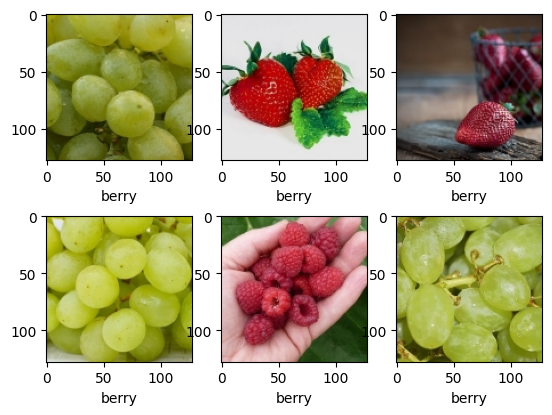

In [15]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrain[i]) ;
    axes[int(i/3)][int(i%3)].set_xlabel(secondLevel[ytrain[i]]) ;
plt.show() ;

In [16]:
def rgb2gray(rgb):
    value = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) ;
    return value ;

In [17]:
xtrainG = np.zeros((xtrain.shape[0],128,128)).astype(np.float32) ;
for i in range(xtrain.shape[0]):
  xtrainG[i] = rgb2gray(xtrain[i]) ;

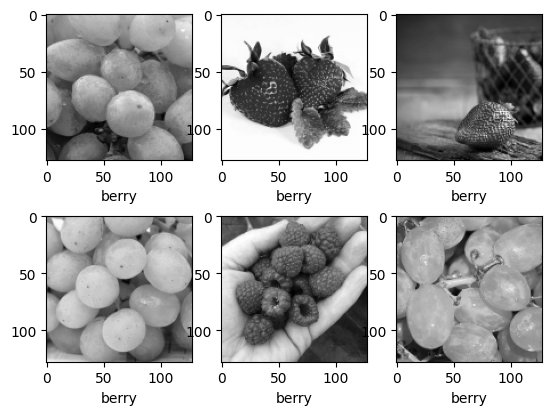

In [18]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrainG[i], cmap='gray') ;
    axes[int(i/3)][int(i%3)].set_xlabel(secondLevel[ytrain[i]]) ;
plt.show() ;

Model Training & Evaluation

In [19]:
colorizer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['accuracy']) ;
colorizer

In [20]:
# !!! WARNING: This optimizes CPU performance - DON'T USE THIS WHEN GPU IS ENABLED !!! (Learnt the hard way!)
# tf.config.run_functions_eagerly(True) ; #  IT ENABLES CONVOLUTION LAYER TO FUNCTION EARLY CAUSING ISSUES IN TENSORS IF GPU IS USED
# tf.data.experimental.enable_debug_mode() ; # IT DISABLES PARALLELISM AND FORCES SEQUENTIAL OPERATION

In [21]:
history = colorizer.fit(xtrainG, xtrain, epochs = 300, batch_size = 50, validation_split=0.05, shuffle=True, verbose = True) ;

Epoch 1/300
114/114 [==============================] - 38s 171ms/step - loss: 0.1170 - accuracy: 0.4275 - val_loss: 0.0885 - val_accuracy: 0.4811
Epoch 2/300
114/114 [==============================] - 19s 168ms/step - loss: 0.0893 - accuracy: 0.4505 - val_loss: 0.0834 - val_accuracy: 0.2534
Epoch 3/300
114/114 [==============================] - 20s 173ms/step - loss: 0.0855 - accuracy: 0.4575 - val_loss: 0.0767 - val_accuracy: 0.3794
Epoch 4/300
114/114 [==============================] - 20s 171ms/step - loss: 0.0828 - accuracy: 0.4656 - val_loss: 0.0703 - val_accuracy: 0.5263
Epoch 5/300
114/114 [==============================] - 20s 173ms/step - loss: 0.0811 - accuracy: 0.4716 - val_loss: 0.0698 - val_accuracy: 0.4648
Epoch 6/300
114/114 [==============================] - 20s 174ms/step - loss: 0.0792 - accuracy: 0.4807 - val_loss: 0.0675 - val_accuracy: 0.4543
Epoch 7/300
114/114 [==============================] - 20s 175ms/step - loss: 0.0780 - accuracy: 0.4890 - val_loss: 0.0845 -

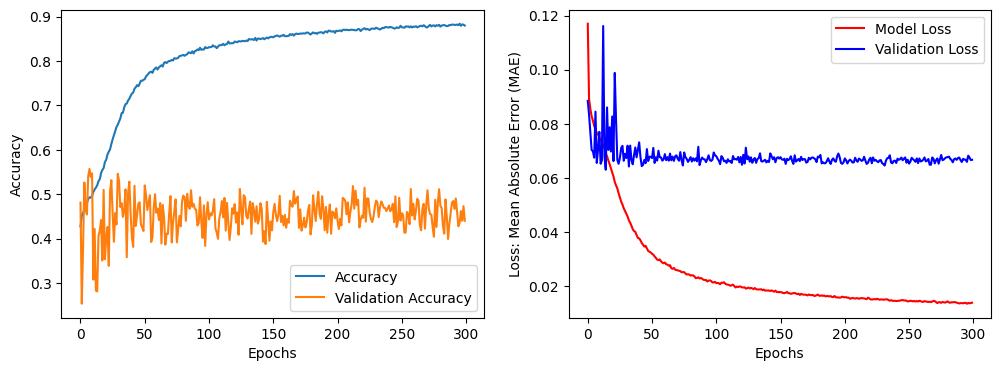

In [22]:
figure, axes = plt.subplots(1,2, figsize=(12,4)) ;
axes[0].plot(history.history['accuracy'], label='Accuracy') ;
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy') ;
axes[0].set_xlabel('Epochs') ;
axes[0].set_ylabel('Accuracy') ;
axes[0].legend() ;
axes[1].plot(history.history['loss'], color='red', label='Model Loss') ;
axes[1].plot(history.history['val_loss'], color='blue', label='Validation Loss') ;
axes[1].set_xlabel('Epochs') ;
axes[1].set_ylabel('Loss: Mean Absolute Error (MAE)') ;
axes[1].legend() ;
plt.show() ;

In [23]:
!pip install pyyaml h5py
colorizer.save('autoEncoderCNN_colorizer_linnaeus5.h5') ;
colorizer.save('autoEncoderCNN_colorizer_linnaeus5.keras') ;

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
del xtrain ;
del ytrain ;

In [25]:
xtestG = np.zeros((xtest.shape[0],128,128)).astype(np.float32) ;
for i in range(xtest.shape[0]):
  xtestG[i] = rgb2gray(xtest[i]) ;

In [26]:
colorizer.evaluate(xtestG, xtest) ;

63/63 [==============================] - 4s 48ms/step - loss: 0.0774 - accuracy: 0.4705


Model Prediction & Output Overview

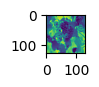

In [27]:
showImage(xtestG, 0) ;

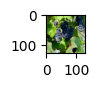

In [28]:
showImage(xtest, 0) ;

In [29]:
coloredOutput = colorizer.predict(xtestG[0].reshape(1,128,128,1)) ;

1/1 [==============================] - 2s 2s/step


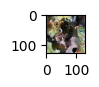

In [30]:
coloredOutput = coloredOutput.astype(np.float32) ;
showImage(coloredOutput, 0) ;

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 47ms/step


<ipython-input-31-e1d8f976fb25>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 61ms/step


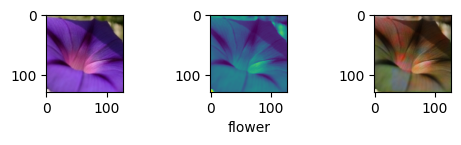

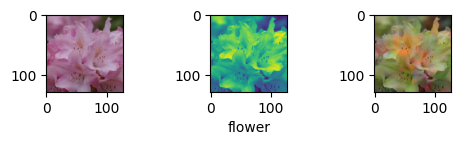

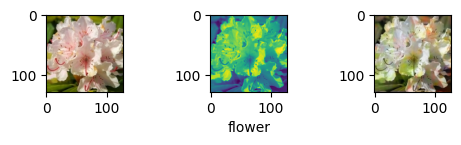

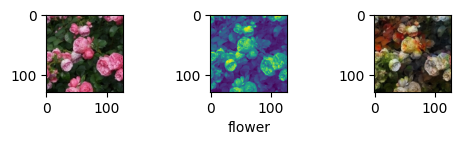

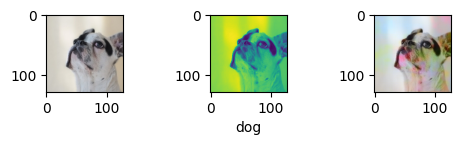

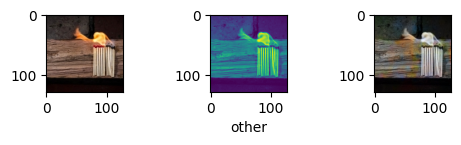

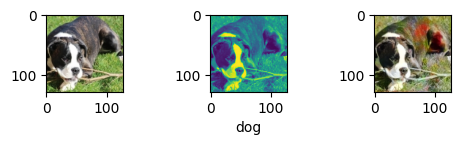

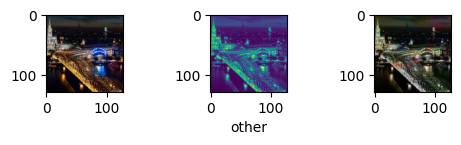

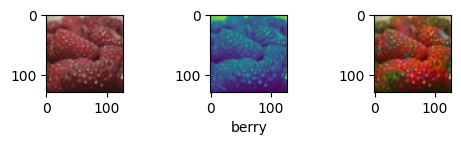

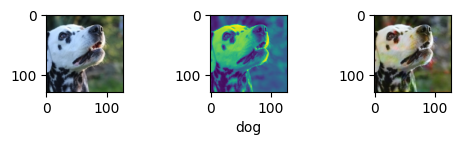

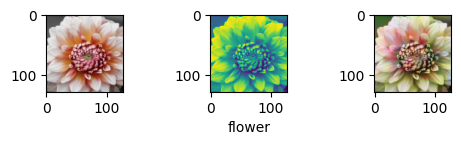

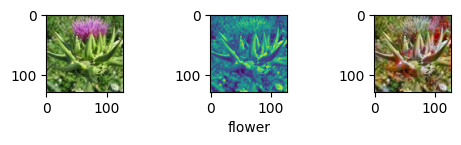

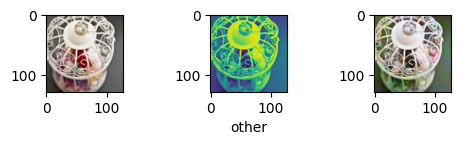

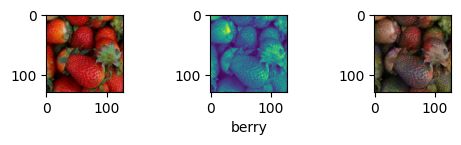

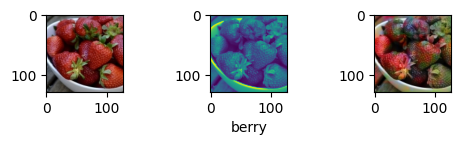

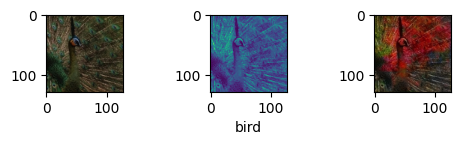

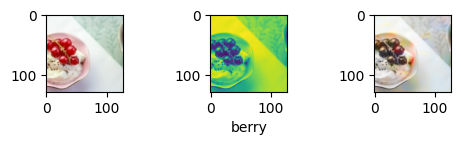

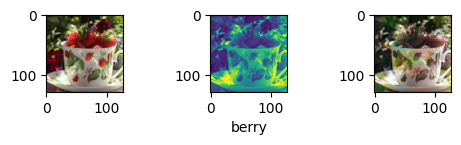

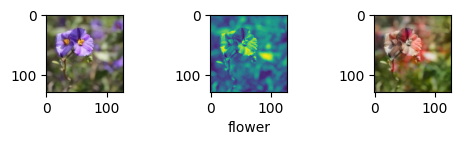

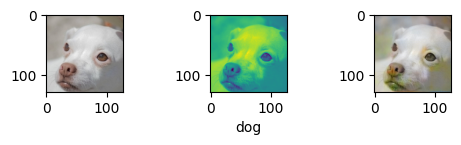

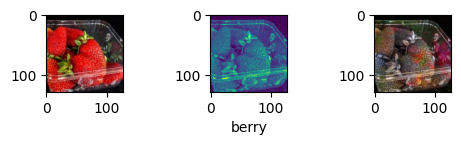

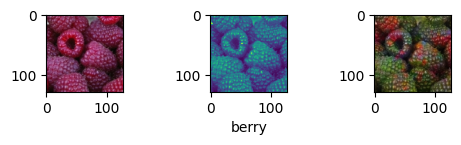

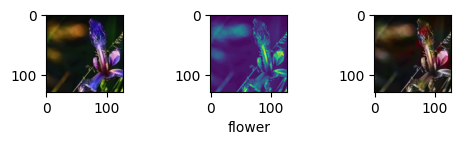

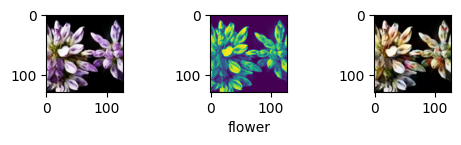

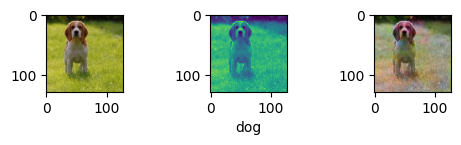

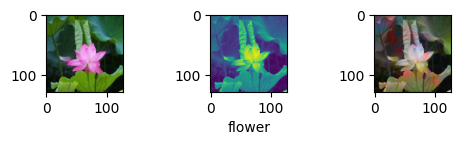

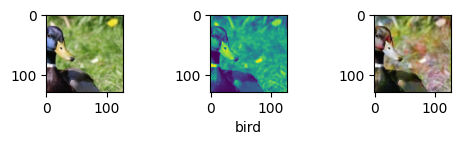

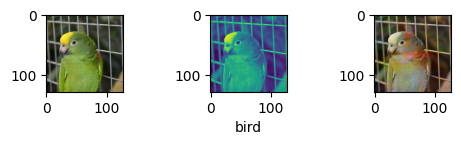

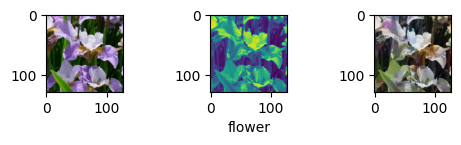

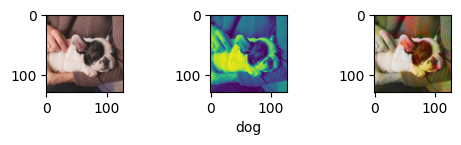

In [31]:
randomIndex = np.random.randint(low=0, high=2000, size=30) ;
for i in randomIndex:
  output = colorizer.predict(xtestG[i].reshape(1,128,128,1)) ;
  output = output.astype(np.float32) ;
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;
  axes[0].imshow(xtest[i]) ;
  axes[1].imshow(xtestG[i], ) ;
  axes[1].set_xlabel(secondLevel[ytest[i]]) ;
  axes[2].imshow(output[0]) ;
plt.show() ;